## [Sentiment Analysis medium blog](https://niteshkumardew11.medium.com/fine-tuning-bert-base-using-pytorch-for-sentiment-analysis-c44a3ce79091)
## [Sentiment Analysis Github notebook](https://github.com/Nitesh0406/-Fine-Tuning-BERT-base-for-Sentiment-Analysis./blob/main/BERT_Sentiment.ipynb)

In [1]:
!pip install transformers
!pip install google_play_scraper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torchvision
import torch.nn as nn
import transformers
from transformers import BertModel
from torch.utils.data import Dataset, DataLoader
import numpy as np

import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [3]:
## Setting up some global variable

COLORS = ['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
from torch.utils import data
sns.set_palette(sns.color_palette(COLORS))
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
fig_size = (10,7)

## Webscraping

In [4]:
# 15 applications
## https://play.google.com/store/apps/details?id= application_id
# you can visit the above link with any of the below app id to see the contents of that application. 
app_packages = [
  'com.anydo',
  'com.todoist',
  'com.ticktick.task',
  'com.habitrpg.android.habitica',
  'cc.forestapp',
  'com.oristats.habitbull',
  'com.levor.liferpgtasks',
  'com.habitnow',
  'com.microsoft.todos',
  'prox.lab.calclock',
  'com.gmail.jmartindev.timetune',
  'com.artfulagenda.app',
  'com.tasks.android',
  'com.appgenix.bizcal',
  'com.appxy.planner'
]

In [5]:
## app_reviews is list of json files.
app_reviews = []

for app_id in tqdm(app_packages):
    for score in range(1,6):
        for review_status in [Sort.MOST_RELEVANT , Sort.NEWEST]:
            rv,_ = reviews(app_id              # google_play_scaper has a module caled reviews that returns
                           ,lang='en'          # app_id,content,review_id,score etc. we can control the 
                           ,country='us'       # scraping by changing variable such as sort,count,filter_score_with etc.
                           ,sort=review_status #
                           ,count =  200 if score == 3 else 100
                           ,filter_score_with=score)

            for r in rv:
                r['app_id'] = app_id     # we are adding two more  columns app_id and review_status.
                r['review_status'] = 'most_relevent' if review_status==Sort.MOST_RELEVANT else 'newest'
            app_reviews.extend(rv)
print(len(app_reviews))

100%|██████████| 15/15 [00:38<00:00,  2.58s/it]

17220


In [6]:
## Get information about app
def json_formatting(obj):
    '''
    This function formates dictionary into json (just for reading purpose)
    '''
    json_object = json.dumps(obj , indent=3, sort_keys= True , default=str)
    print(highlight(json_object , JsonLexer() , TerminalFormatter()))

json_formatting(app_reviews[0])

{
   "app_id": "com.anydo",
   "at": "2022-02-22 03:24:11",
   "content": "After a task is done a duplicate will appear for the same task causing me to have to remove one. Then even if I haven't done a task that day it will still have one of them marked done (the duplicate is always unmarked). I believe this is due to an error in the day tracking it. It seems to be unable to tell whether or not the day is ended. It's rather unfortunate considering it is very easy to personalize and even allows you to create a grocery list. Uninstalled and will not be reinstalling :/",
   "repliedAt": "2022-02-24 16:34:04",
   "replyContent": "We would be happy to help you resolve all of the issues you have encountered should you send us a bug report via (Settings-Bug Report).\n",
   "reviewCreatedVersion": null,
   "reviewId": "e056d73d-0ff3-4890-8848-8cfdfb63b7be",
   "review_status": "most_relevent",
   "score": 1,
   "thumbsUpCount": 3,
   "userImage": "https://play-lh.googleusercontent.com/a-/AFdZu

In [7]:
len(app_reviews)

17220

In [8]:
reviews_df = pd.DataFrame(app_reviews)
reviews_df.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,app_id,review_status
0,e056d73d-0ff3-4890-8848-8cfdfb63b7be,Emie Hickman,https://play-lh.googleusercontent.com/a-/AFdZu...,After a task is done a duplicate will appear f...,1,3,None,2022-02-22 03:24:11,We would be happy to help you resolve all of t...,2022-02-24 16:34:04,com.anydo,most_relevent
1,a6b21375-312e-41b5-90ab-3d56273ca01b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This app was great until the latest update and...,1,24,4.12.0.5,2019-01-12 13:20:28,"We are sorry you feel this way, please note th...",2019-01-27 15:44:37,com.anydo,most_relevent


In [9]:
 reviews_df.to_csv('review.csv',header=True,index=False)

In [10]:
reviews_df.shape

(17220, 12)

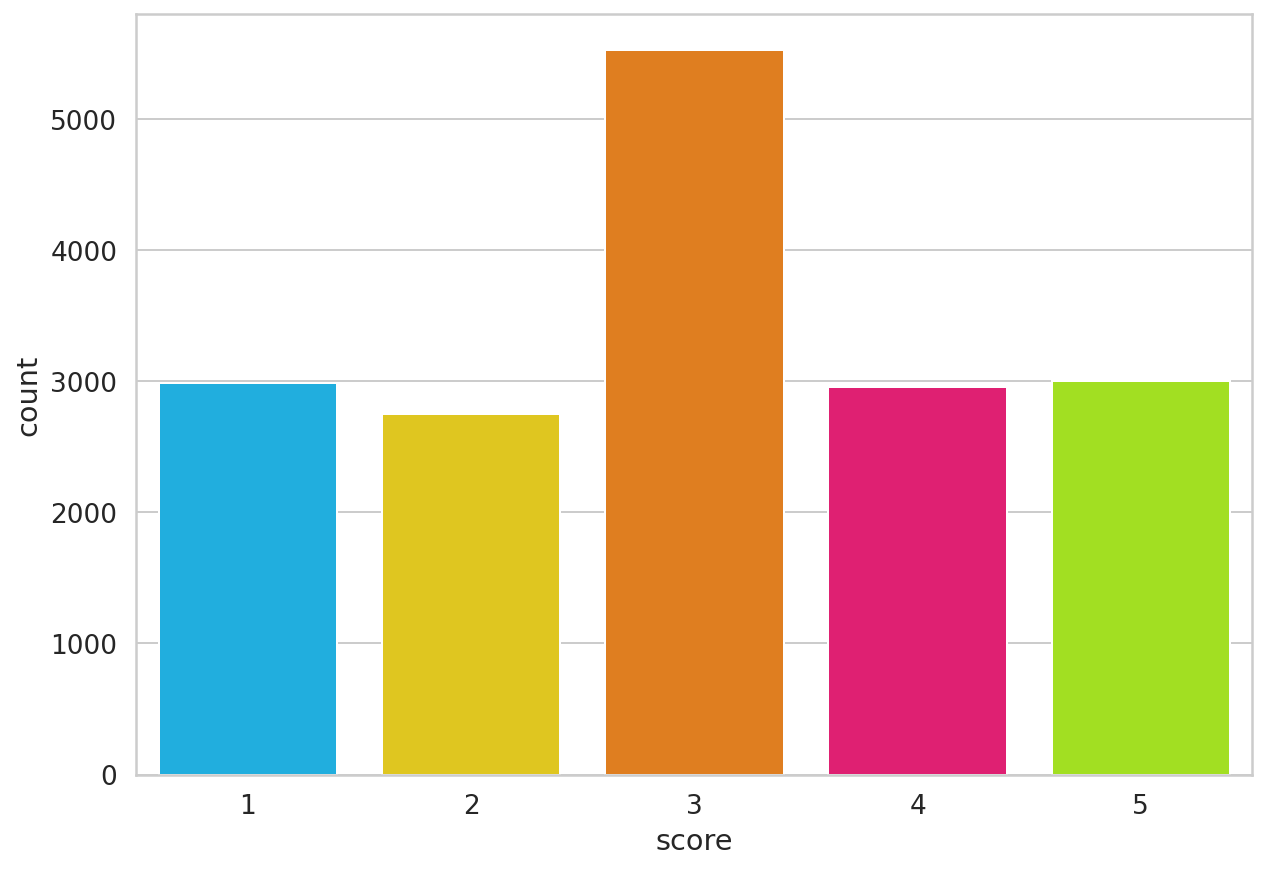

In [11]:
plt.figure(figsize=fig_size)
sns.countplot(reviews_df.score)
plt.xlabel('score')
plt.show()

In [12]:
def get_sentiment(score):
    if score<=2:
        return 0 # negative sentiment
    elif score==3:
        return 1 # neutral sentiment
    else:
        return 2 # positive sentiment
    

reviews_df['sentiment'] = reviews_df.score.apply(get_sentiment)
reviews_df.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,app_id,review_status,sentiment
0,e056d73d-0ff3-4890-8848-8cfdfb63b7be,Emie Hickman,https://play-lh.googleusercontent.com/a-/AFdZu...,After a task is done a duplicate will appear f...,1,3,None,2022-02-22 03:24:11,We would be happy to help you resolve all of t...,2022-02-24 16:34:04,com.anydo,most_relevent,0
1,a6b21375-312e-41b5-90ab-3d56273ca01b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This app was great until the latest update and...,1,24,4.12.0.5,2019-01-12 13:20:28,"We are sorry you feel this way, please note th...",2019-01-27 15:44:37,com.anydo,most_relevent,0


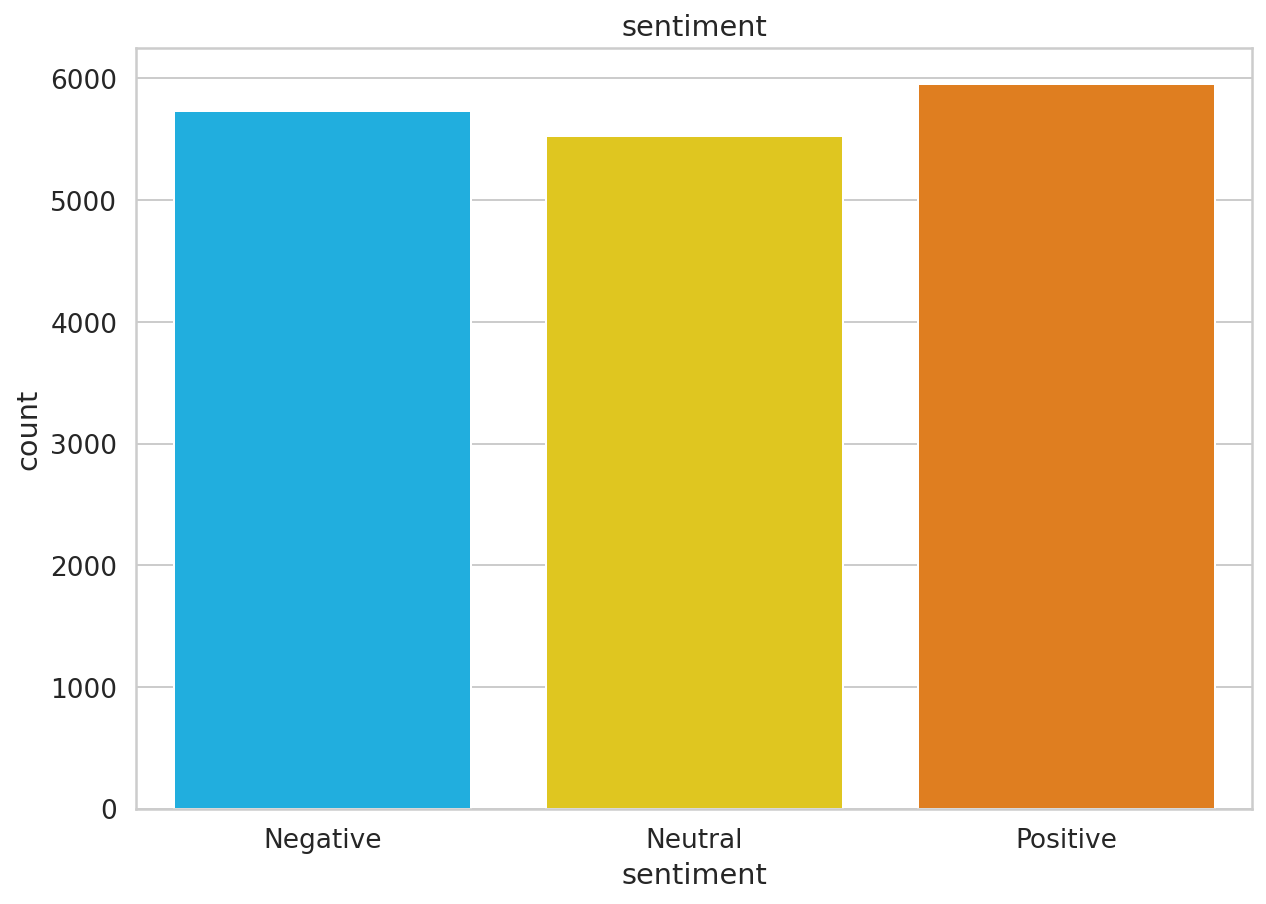

In [13]:
plt.figure(figsize=fig_size)
sns.countplot(reviews_df['sentiment'])
plt.xticks([0, 1, 2],['Negative','Neutral','Positive'])
plt.title('sentiment')
plt.show()

## Our dataset is ready, Scrapped properly
# Prepare training , validation data
--> convert reviews into tokens --> convert tokens into token ids --> set max len --> creating padding --> all this will done by tokenizer.encode_plus

In [14]:
bert_model_name = 'bert-base-cased'
tokenizer = transformers.BertTokenizer.from_pretrained(bert_model_name)

sample_text = "originally gave this a 2 star but I think it only deserves 1. I simply can't wrap my head around the following. picture this, you add a task to your list. the reminder feature is on.you want to change the time on the reminder feature so you click it."
               
tokens = tokenizer.tokenize(sample_text)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(f'{sample_text}')
print('='*60)
print(tokens)
print('='*60)
print(ids)

originally gave this a 2 star but I think it only deserves 1. I simply can't wrap my head around the following. picture this, you add a task to your list. the reminder feature is on.you want to change the time on the reminder feature so you click it.
['originally', 'gave', 'this', 'a', '2', 'star', 'but', 'I', 'think', 'it', 'only', 'deserves', '1', '.', 'I', 'simply', 'can', "'", 't', 'wrap', 'my', 'head', 'around', 'the', 'following', '.', 'picture', 'this', ',', 'you', 'add', 'a', 'task', 'to', 'your', 'list', '.', 'the', 'reminder', 'feature', 'is', 'on', '.', 'you', 'want', 'to', 'change', 'the', 'time', 'on', 'the', 'reminder', 'feature', 'so', 'you', 'click', 'it', '.']
[2034, 1522, 1142, 170, 123, 2851, 1133, 146, 1341, 1122, 1178, 18641, 122, 119, 146, 2566, 1169, 112, 189, 10561, 1139, 1246, 1213, 1103, 1378, 119, 3439, 1142, 117, 1128, 5194, 170, 4579, 1106, 1240, 2190, 119, 1103, 15656, 2672, 1110, 1113, 119, 1128, 1328, 1106, 1849, 1103, 1159, 1113, 1103, 15656, 2672, 1177

In [15]:
# special tokens
print(tokenizer.sep_token , tokenizer.sep_token_id)
print(tokenizer.cls_token,tokenizer.cls_token_id)
print(tokenizer.unk_token,tokenizer.unk_token_id)
print(tokenizer.pad_token,tokenizer.pad_token_id)

[SEP] 102
[CLS] 101
[UNK] 100
[PAD] 0


## Hugging face library provides another function called tokenizer.encode_plus() which we will use to perform almost entire preprocessing steps in one go. It

- converts reviews into tokens
- adds [CLS] token at the beginning of input
- performs padding if sequence length is less than max_len
- performs truncation if sequence length is greater than max_len
- adds [SEP] token at the end of sequence.

In [16]:
encoding = tokenizer.encode_plus(
      sample_text,
      add_special_tokens=True,
      max_length=128,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

In [17]:
print(encoding['input_ids'].shape)
print(encoding['input_ids'])
print()
print()
print(encoding['attention_mask'].shape)
print(encoding['attention_mask'])

torch.Size([1, 128])
tensor([[  101,  2034,  1522,  1142,   170,   123,  2851,  1133,   146,  1341,
          1122,  1178, 18641,   122,   119,   146,  2566,  1169,   112,   189,
         10561,  1139,  1246,  1213,  1103,  1378,   119,  3439,  1142,   117,
          1128,  5194,   170,  4579,  1106,  1240,  2190,   119,  1103, 15656,
          2672,  1110,  1113,   119,  1128,  1328,  1106,  1849,  1103,  1159,
          1113,  1103, 15656,  2672,  1177,  1128, 13440,  1122,   119,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,  

In [18]:
reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,app_id,review_status,sentiment
0,e056d73d-0ff3-4890-8848-8cfdfb63b7be,Emie Hickman,https://play-lh.googleusercontent.com/a-/AFdZu...,After a task is done a duplicate will appear f...,1,3,None,2022-02-22 03:24:11,We would be happy to help you resolve all of t...,2022-02-24 16:34:04,com.anydo,most_relevent,0
1,a6b21375-312e-41b5-90ab-3d56273ca01b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This app was great until the latest update and...,1,24,4.12.0.5,2019-01-12 13:20:28,"We are sorry you feel this way, please note th...",2019-01-27 15:44:37,com.anydo,most_relevent,0
2,1177566d-6443-42ab-8320-7e8b3342cec8,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Product images show the month view at the top ...,1,4,None,2019-07-06 21:14:32,We appreciate the feedback. The images for iOS...,2019-07-09 11:45:56,com.anydo,most_relevent,0
3,82d2f0c3-dbff-4722-89fa-d8af997ba4ab,Hyco Syco,https://play-lh.googleusercontent.com/a/AItbvm...,This app used to be great when paired with Ale...,1,3,4.15.9.6,2020-06-17 17:32:55,"Sorry about that, our team is currently workin...",2020-06-18 06:47:52,com.anydo,most_relevent,0
4,9f47e332-2c56-426c-8430-ce8ffde55706,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Very annoyed that I have to keep signing in an...,1,21,4.15.8.11,2019-09-29 16:03:25,"Hi, that's odd, please send us a bug report in...",2019-10-02 19:51:43,com.anydo,most_relevent,0


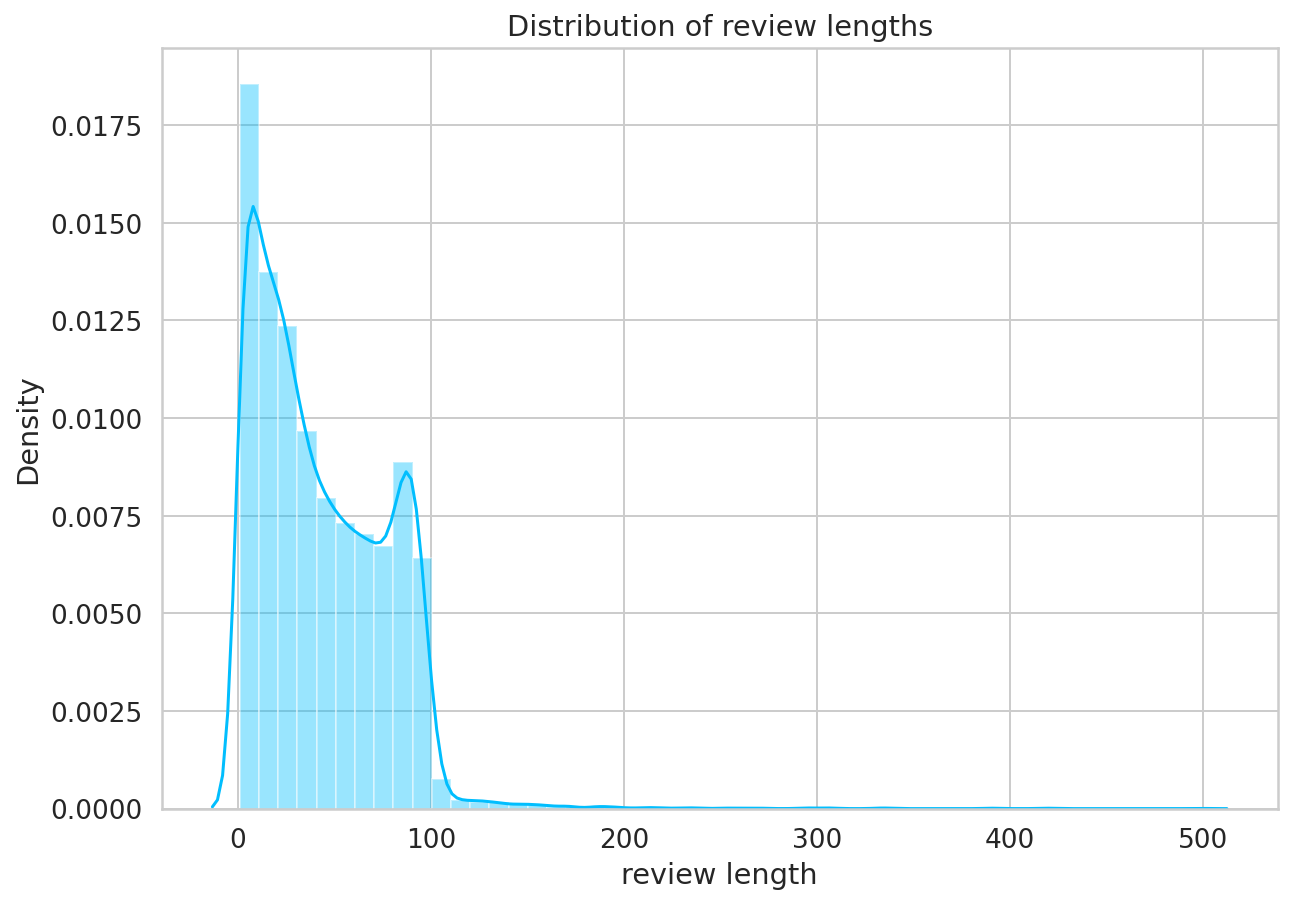

In [19]:
# max length of sequence 

lengths = np.array([len(x.split()) for x in reviews_df.content])
plt.figure(figsize = fig_size)
sns.distplot(lengths)
plt.xlabel('review length')
plt.title('Distribution of review lengths')
plt.show()

In [20]:
### Train , val and test data 
from sklearn.model_selection import train_test_split

train_df , test_df  = train_test_split(reviews_df, test_size = 0.2, random_state = RANDOM_SEED, shuffle = True)
val_df , test_df  = train_test_split(test_df, test_size = 0.5, random_state = RANDOM_SEED, shuffle = True)

print(train_df.shape , test_df.shape , val_df.shape)

(13776, 13) (1722, 13) (1722, 13)


## Dataset and Dataloader
We will use pytorch for fine tuing our BERT model for Sentiment analysis and we will use pytorch module such as Dataset and Dataloader which will finally convert out data into batches.

We designed a class called GoogleAppReview which is child class of Dataset provided by pytorch and this class contains blue print for the data which will be feed to our BERT model.

In [21]:
class GoogleAppReview(Dataset):
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self,index):
        review = self.review[index]
        encoding = self.tokenizer.encode_plus(
                          review,
                          add_special_tokens=True,
                          max_length=128,
                          truncation=True,
                          return_token_type_ids=False,
                          pad_to_max_length=True,
                          return_attention_mask=True,
                          return_tensors='pt')
        
        return {'review' : review,
                'input_id': encoding['input_ids'].flatten(),
                'attention_mask':encoding['attention_mask'].flatten(),
                'target': torch.tensor(self.target[index], dtype = torch.long)
               }
        

## Now we will create class object training_data, validation_data and test_data of class GoogleAppReview.

In [22]:
tokenizer = transformers.BertTokenizer.from_pretrained(bert_model_name)
MAX_LEN = 128

training_data = GoogleAppReview(review = train_df.content.to_numpy(),
                               target = train_df.sentiment.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LEN)

validation_data = GoogleAppReview(review = val_df.content.to_numpy(),
                               target = val_df.sentiment.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LEN)

test_data = GoogleAppReview(review = test_df.content.to_numpy(),
                               target = test_df.sentiment.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LEN)

In [23]:
print(len(training_data),len(test_data),len(validation_data))

13776 1722 1722


In [24]:
## DataLoader
BATCH_SIZE = 16
train_loader = DataLoader(training_data , batch_size = BATCH_SIZE , shuffle = True)
test_loader = DataLoader(test_data , batch_size = BATCH_SIZE , shuffle = False)
val_loader = DataLoader(validation_data , batch_size = BATCH_SIZE , shuffle = False)

In [25]:
sample_batch = next(iter(train_loader))
sample_batch.keys()

dict_keys(['review', 'input_id', 'attention_mask', 'target'])

In [26]:
print(sample_batch['review'][0])
print(sample_batch['input_id'][0])
print(sample_batch['attention_mask'][0])
print(sample_batch['target'][0])
print('='*50)
print(sample_batch['input_id'].shape,sample_batch['attention_mask'].shape,sample_batch['target'].shape)

I never thought I'd turn to Microsoft for the optional task tracker but here I am! I used Any.Do for a weekly but it was "too helpful" and pushed me into a corner. Switched to Google Tasks which has nice integration with Gmail and Google calendar but was too simple for a power user. This app is just right. It does the simple things with ease, allows for ample customization, let's you set up your day like any.do without being too inflexible, and has decent cross platform integrations.
tensor([  101,   146,  1309,  1354,   146,   112,   173,  1885,  1106,  6998,
         1111,  1103, 13027,  4579,  1854,  1200,  1133,  1303,   146,  1821,
          106,   146,  1215,  6291,   119,  2091,  1111,   170,  5392,  1133,
         1122,  1108,   107,  1315, 14739,   107,  1105,  2873,  1143,  1154,
          170,  2655,   119,   156, 18548,  1174,  1106,  7986, 11513,  1116,
         1134,  1144,  3505,  9111,  1114,   144, 14746,  1105,  7986,  8729,
         1133,  1108,  1315,  3014,  1111, 

## Model Selection
The BERT model comes with two configurations or we can say two different sizes BERT-base and BERT-large and we haven't talked about which model we are going to select. Performance wise BERT-large is more accurate as it has more bert-layer(24) and embedding size = 1024 but it is very hard to fine tune as I do not have any powerful GPUs on other hand BERT-base comes with 12 bert-layer and 768 embedding size which is much more easy to train as compare to BERT-large and performance wise also BERT-base give reasonably good performance.

By considering all those factors I will use BERT-base for our sentiment analysis model.

In [27]:
# Load BERT base model

bert_model_name = 'bert-base-cased'
bert_model = BertModel.from_pretrained(bert_model_name)


## testing the output of bert model
x = bert_model(sample_batch['input_id'].view(BATCH_SIZE,MAX_LEN)
               ,sample_batch['attention_mask'].view(BATCH_SIZE,MAX_LEN))


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
print('Last hidden layer size for input as batch',x[0].shape)
print('Pooled output size for input as batch',x[1].shape)

Last hidden layer size for input as batch torch.Size([16, 128, 768])
Pooled output size for input as batch torch.Size([16, 768])


## Model Architecture
We will add one more linear layer on top of the BERT-base model which takes inputs from a pooled layer of BERT base and generates 3 output for each input. These three outputs will indicate the chance of a review to its respective sentiments where First output represents Negative and second and third output represents Neutral and positive respectively.

In [29]:
## build model 
# input to the model -->review ids and attention mask

class SentimentClassifier(nn.Module):
    def __init__(self,num_classes):
        super(SentimentClassifier,self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(p = 0.3)
        self.linear = nn.Linear(self.bert.config.hidden_size,num_classes)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self,input_ids , attention_mask):
        temp = self.bert(input_ids,attention_mask) # Here we have added one linear layer on top of 
        pooled_output = temp[1]                    # BERT-base with number of output = 3 
        out = self.dropout(pooled_output)          # 
        out = self.linear(out)
        return out

## Above model takes a batch as input and linear layer as (size = 3) as output, to get the final output we must apply softmax at the end. Let's check with a sample batch.

In [30]:
num_classes = 3
model = SentimentClassifier(num_classes)

sample_linear_output = model(sample_batch['input_id']
                             ,sample_batch['attention_mask'])

s = nn.Softmax(dim=1)
final_out = s(sample_linear_output)
final_out

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[0.4179, 0.4275, 0.1546],
        [0.4438, 0.3791, 0.1771],
        [0.3160, 0.3924, 0.2916],
        [0.3448, 0.2625, 0.3928],
        [0.3351, 0.4721, 0.1928],
        [0.6845, 0.2076, 0.1079],
        [0.4128, 0.4278, 0.1594],
        [0.5874, 0.3415, 0.0710],
        [0.3967, 0.4113, 0.1920],
        [0.4903, 0.4047, 0.1049],
        [0.3661, 0.3420, 0.2919],
        [0.4718, 0.2083, 0.3200],
        [0.4810, 0.3497, 0.1693],
        [0.4955, 0.3169, 0.1876],
        [0.3725, 0.3922, 0.2353],
        [0.3284, 0.4848, 0.1868]], grad_fn=<SoftmaxBackward0>)

## The following initial steps are performed to train any deep learning model using pytorch which are

- define loss function
- define optimizer
- define scheduler (it will modify learning rate after each iteration that speed-up the convergence. using it is optional but recommended)

## Below function trains model (forward pass and backward pass) for one epoch and also calculate accuracy and average loss for an epoch.

In [31]:
## loss and optimizer
learning_rate = 1e-5
EPOCHS = 20
total_steps = len(train_loader) * EPOCHS

criterian = torch.nn.CrossEntropyLoss()

optimizer = transformers.AdamW(params = model.parameters(),lr = learning_rate, correct_bias= False)

scheduler = transformers.get_linear_schedule_with_warmup(optimizer = optimizer,
                                                        num_warmup_steps = 0,
                                                        num_training_steps = total_steps)

In [32]:
def train_model(model, data_loader, criterian, optimizer, scheduler, BATCH_SIZE ,MAX_LEN, n_examples):
    
    model.train()
    train_loss = []
    correct_pred = 0
    
    for d in data_loader:
        input_ids = d['input_id']
        attention_masks = d['attention_mask']
        targets = d['target']

        # forward prop
        predictions = model(input_ids , attention_masks)
        loss = criterian(predictions, targets)
        _,pred_classes = torch.max(predictions, dim=1)
        #backprop
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # hack to avoid gradient explotion
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        # training loss and number of correct prediction
        train_loss.append(loss.item())
        correct_pred += torch.sum(pred_classes==targets)
    return correct_pred / n_examples , np.mean(train_loss)

## This fuction evaluate model performance on evaluation data for every epoch by calculation accuracy and average loss.

In [33]:
def eval_model(model, data_loader, criterian, BATCH_SIZE ,MAX_LEN, n_examples):
    model.eval()  # to make model in evaluastion model , Dropout will not apply 
    eval_loss = []
    correct_pred = 0
    
    with torch.no_grad():  # calculation of gradient is not required on evaluation
        for d in data_loader:
            input_ids = d['input_id']
            attention_masks = d['attention_mask']
            targets = d['target']

            # forward prop
            predictions = model(input_ids , attention_masks)
            loss = criterian(predictions, targets)
            _,pred_classes = torch.max(predictions, dim=1)

            eval_loss.append(loss.item())
            correct_pred += torch.sum(pred_classes==targets)
    return correct_pred / n_examples , np.mean(eval_loss)

In [ ]:
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # training part 
    
    print(f'epoch : {epoch+1}/{EPOCHS}')
    model = SentimentClassifier(num_classes)
    train_acc , train_loss = train_model(model,
                                         train_loader,
                                         criterian,
                                         optimizer, 
                                         scheduler, 
                                         BATCH_SIZE,
                                         MAX_LEN,
                                         len(train_df))
    # validation part
    
    val_acc , val_loss = eval_model(model, 
                                    val_loader,
                                    criterian,
                                    BATCH_SIZE,
                                    MAX_LEN, len(val_df))
    
    # saving training logs
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    print(f'train_loss: {train_loss}, train_acc: {train_acc} ,val_loss: {val_loss}, val_acc: {val_acc}')
    
    # saving model if performance improved 
    
    if val_acc > best_accuracy:
        best_model_name = f'best_model_state_{val_acc}.bin'
        torch.save(model.state_dict(), best_model_name)
        best_accuracy = val_acc

epoch : 1/20


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Evaluation on Test Data

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in tqdm(data_loader):

            texts = d["review"]
            input_ids = d["input_id"]
            attention_mask = d["attention_mask"]
            targets = d["target"]

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_loader)

In [ ]:
from sklearn.metrics import classification_report

class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Testing model on unseen data

In [ ]:
### Predicting on Raw text data

def get_sentiment(sample_review):
    # get input ids and attention mask
    encode_sample_review = tokenizer.encode_plus(
                              sample_review,
                              add_special_tokens=True,
                              max_length=128,
                              truncation=True,
                              return_token_type_ids=False,
                              pad_to_max_length=True,
                              return_attention_mask=True,
                              return_tensors='pt')

    input_ids = encode_sample_review['input_ids']
    attention_mask = encode_sample_review['attention_mask']
    # predict output
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    # output as probabilities
    pred_probs = F.softmax(output,dim=1).detach().numpy().reshape(3)
    
    class_names = ['negative', 'neutral', 'positive']
    data = {'class_names':class_names, 
            'value':pred_probs} 

    # Create DataFrame 
    df = pd.DataFrame(data)
    # plot bars for probability of each sentiment
    sns.barplot(x='value', y='class_names', data=df, orient='h')
    plt.ylabel('sentiment')
    plt.xlabel('probability')
    plt.xlim([0, 1]);
    print(f'Review text: {sample_review}')
    print('=*'*50)

    print(f'negative % : {pred_probs[0]:.4f}, neutral % : {pred_probs[1]:.4f}, positive % : {pred_probs[2]:.4f}')

    print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
sample = '''I would have gave it 5 stars, but it was kind of weird, because when I tried to exit the game, it kept pulling me back inside of it, but I did not want that to happen, so I went to app store, I had to reset my phone, but it's still worth. I had to go to app store and I have to give me a one song because. Filled star wrong.anyway, I spelled that wrong too even star. I gave it one star because it was kind of creepy. He was following my finger, I got really scared, so I had to exit the game'''

In [ ]:
get_sentiment(sample)